In [ ]:
# Directorio de trabajo
import sys
import os
from google.colab import drive
drive.mount("/content/drive", force_remount = True)
DIR = "/content/drive/My Drive/bio/"

%cd "$DIR"

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import plot_roc_curve

%matplotlib inline
%load_ext autoreload
%autoreload 2

seed = 2021

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
_ = tf.device('/device:GPU:0')

In [79]:
train_dir = 'UADFV+TIMIT_faces_training/'
test_dir = 'CelebDF-Test/'
log_dir = 'logs/'
target_size = (256, 256)

In [81]:
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    shear_range=0.3,
    zoom_range=0.3,
    validation_split=0.1
)

val_datagen = ImageDataGenerator(
    validation_split=0.1
)

test_datagen = ImageDataGenerator()

train_data = train_datagen.flow_from_directory(
    directory=train_dir,
    class_mode='binary',
    batch_size=32,
    seed=seed,
    target_size=target_size,
    subset="training"
)

val_data = val_datagen.flow_from_directory(
    directory=train_dir,
    class_mode='binary',
    batch_size=32,
    seed=seed,
    target_size=target_size,
    subset="validation"
)

test_data = test_datagen.flow_from_directory(
    directory=test_dir,
    class_mode='binary',
    batch_size=32,
    shuffle = False,
    seed=seed,
    target_size=target_size,
)

num_train = train_data.samples
num_val = val_data.samples
num_test = test_data.samples

Found 1647 images belonging to 2 classes.
Found 182 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [82]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense

"""
- kernel_constraint=maxnorm(3) on conv and dense layers
"""

model = Sequential()
model.add(Conv2D(16, (3, 3), input_shape=(*target_size, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (1, 1)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten()) 
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [83]:
# Compile model
metric = tf.keras.metrics.AUC(name='auc')
loss = 'binary_crossentropy' #'hinge'

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[metric])

cb_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=log_dir + 'data3-DL.h5',
    save_weights_only=True,
    monitor='auc',
    mode='max',
    save_best_only=True
)

callbacks = [
    cb_model_checkpoint
]

In [ ]:
history = model.fit(
    train_data,
    epochs=50,
    validation_data=val_data,
    callbacks=callbacks
)

In [104]:
_ , auc_test = model.evaluate(test_data)

19/19 [==============================] - 2s 80ms/step - loss: 1.2189 - auc: 0.6580


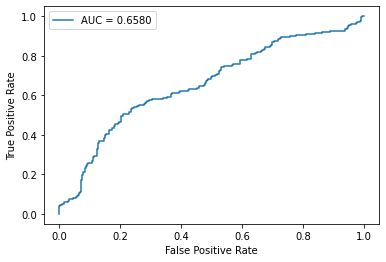

In [105]:
from sklearn.metrics import roc_curve

y_pred = model.predict(test_data).ravel()
fpr, tpr, _ = roc_curve(test_data.classes, y_pred)
plt.plot(fpr, tpr, label=f"AUC = {auc_test:.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()